### Android packets analysis
I wanted to monitor which apps where using the most my internet connection while idle, so I set up a MITM attack to my own phone lan, while connected to Wi-Fi, then sniffed packets sent. I used [ettercap](https://www.ettercap-project.org/ettercap/) for the attack, and [wireshark](https://www.wireshark.org/) for packet captures. Data comes from wireshark's `Statistics` -> `IPv4 Statistics` -> `All Addresses` tab. This is the data right outside wireshark, after an hour of monitoring:

In [21]:
import pandas as pd
data = pd.read_csv('stats.csv',sep=',',decimal='.')
data.head()

,level,parent,Topic / Item,Count,Average,Min val,Max val,Rate (ms),Percent,Burst rate,Burst start,Unnamed: 11
0,0,NaN,All Addresses,1454,NaN,NaN,NaN,0.0003,100%,0.58,1300.488,NaN
1,1,/All Addresses,69.10.180.70,96,NaN,NaN,NaN,0.0000,6.60%,0.08,4332.651,NaN
2,1,/All Addresses,66.102.1.188,36,NaN,NaN,NaN,0.0000,2.48%,0.08,4574.738,NaN
3,1,/All Addresses,52.38.149.111,26,NaN,NaN,NaN,0.0000,1.79%,0.06,61.716,NaN
4,1,/All Addresses,52.10.60.207,6,NaN,NaN,NaN,0.0000,0.41%,0.02,47.213,NaN


Let's consider only data with `level == 1` since `0` is the sum for all addresses. I will also remove local addresses, since they where only used for ICMP requests:

In [84]:
data = data[data['level'] == 1]
data = data[~data['Topic / Item'].str.contains('192.168.1')]

Next I want to show the resolved address, using the `whois` command. Since it can be slow I already made a csv with all the resolved addresses:

In [167]:
import subprocess

def whois(address,field):
    command = "whois {} | grep -m 1 {} | cut -d ':' -f2"
    return subprocess.check_output(command.format(address,field), shell=True).decode('utf-8').strip()

def resolve(address):
    res = whois(address,'descr')
    if res == u'':
        res = whois(address, 'org-name')
    if res == u'':
        res = whois(address, 'OrgName')
    if res == u'':
        res = 'Unknown'
    return res

try:
    resolved = pd.read_csv('resolved.csv',header=None,names=['Resolved'])
except:
    resolved = data['Topic / Item'].copy().apply(lambda x: resolve(x))
    resolved.to_csv('resolved.csv')
    resolved = pd.read_csv('resolved.csv',header=None,names=['Resolved'])
resolved[resolved.Resolved.str.contains('PAT/NAT IP addresses POP 0118 for')] = 'Fastweb Networks Block'
resolved[resolved.Resolved.str.contains('Amazon')] = 'Amazon'
data['Resolved address'] = resolved
resolved.head()

,Resolved
1,Motorola Mobility LLC
2,Google LLC
3,Amazon
4,Amazon
5,Amazon


I needed to consider different fields of `whois` command to actually have a useful indication of the app that was making the connection. Also one of the entries had quite a misleading description, which I fixed manually. I didn't actually understand from which app all of the connections where coming from, however I think they are interesting results.

Let's plot the number of package sent:

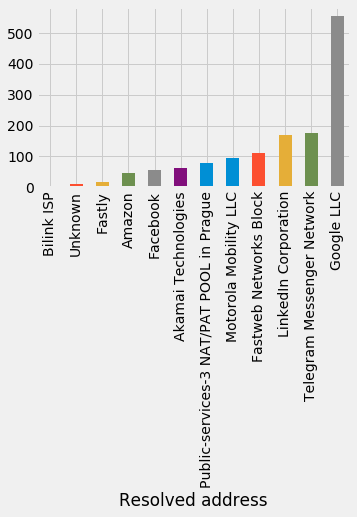

In [168]:
import matplotlib.pyplot as plt
from scipy.constants import golden
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(5.0, 5.0/golden))
address_count = data['Count']
address_count.index = data['Resolved address']
address_count=address_count.groupby(address_count.index).aggregate(sum)
address_count.sort_values().plot.bar()
plt.show()

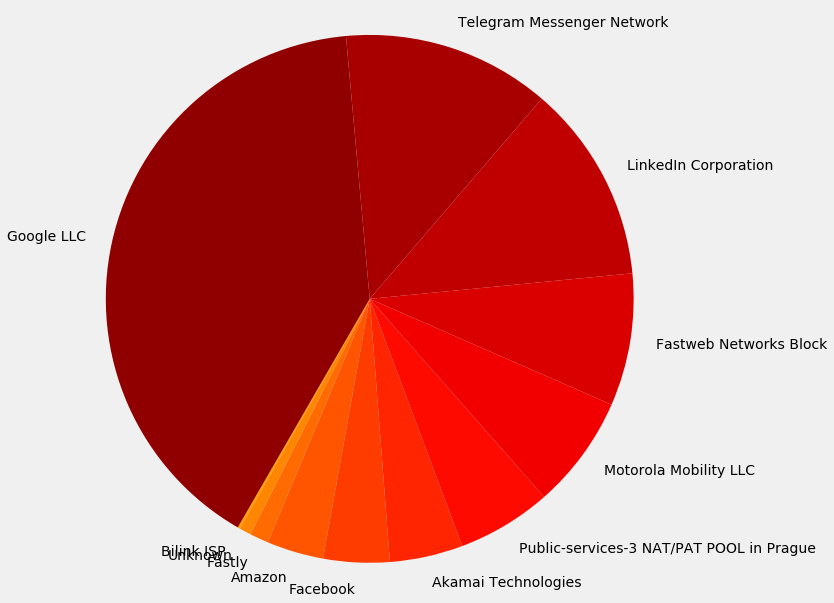

In [169]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
color = cm.hot_r(np.linspace(.4,.8, len(address_count)))
address_count.name = ''
address_count.sort_values().plot.pie(figsize=(10,10),colors=color, legend=False,startangle=240)
plt.axis('equal')
plt.show()

Since I don't have Facebook and don't know what some of those entries are, and I don't have Facebook (may be WhatsApp though) I'll try to stop those apps that make those unwanted connections.